In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from myplots import roundup, rounddown, find_decimal_fold, percentile_cut_off, rarefaction_calc, rarefaction_plot,draw_correlation_scatter
from matplotlib.ticker import FormatStrFormatter
import cPickle as pickle
from Bio.SeqUtils import GC
import seaborn as sns
import random
from scipy.stats import pearsonr

from pop_organize import get_sample_data, get_sample_with_dfs
from SufficientStatistics import *
from MyFunctionsShani import *


done1
done2


# stage 1: improve ins1 and ins2 prediction:
1. work on the combination and not sequence level
2. check if there are very low probabilities in the tables and add priors
3. cap the low predicted frequencies

In [ ]:
sample_name='HIP13505'

In [ ]:


sample_df = pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/%s.tsv" % sample_name) 
sample_df_non_prod = sample_df[sample_df['sequenceStatus'] != 'In']

In [ ]:
sample_df_non_prod.columns.get_values().tolist()

In [ ]:
columns_to_check=['cdr3Length', 'vGeneName', 'dFamilyName','jGeneName','vDeletion', 'n1Insertion','d5Deletion', 'd3Deletion',
                 'n2Insertion', 'jDeletion',  'vIndex',  'n1Index',  'dIndex',  'n2Index',  'jIndex']

In [ ]:
sample_df_non_prod_combinations=sample_df_non_prod.drop_duplicates(subset=columns_to_check)

In [ ]:
zeros=sample_df_non_prod_combinations[sample_df_non_prod_combinations['n1Insertion']==0]

In [ ]:
zeros[columns_to_check]

In [ ]:
print len (sample_df_non_prod_combinations)
print len (sample_df_non_prod)

In [ ]:
float(9287-8616)/9287

In [ ]:
# correction of genIns1SeqDF to enable combinations. this funciton was copied to eclipse, ins2 function was updated similarly. 

def genIns1SeqDF(sample_name,basicUnit):
    
    columns_to_check=['cdr3Length', 'vGeneName', 'dFamilyName','jGeneName','vDeletion', 'n1Insertion','d5Deletion', 'd3Deletion',
                 'n2Insertion', 'jDeletion',  'vIndex',  'n1Index',  'dIndex',  'n2Index',  'jIndex']
    
    sample_df = pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/%s.tsv" % sample_name) 
    sample_df_non_prod = sample_df[sample_df['sequenceStatus'] != 'In']
    sample_df_non_prod_combinations=sample_df_non_prod.drop_duplicates(subset=columns_to_check) #work in the combination level
    
    if basicUnit=='seq':
        df=sample_df_non_prod
    else:
        df=sample_df_non_prod_combinations
    
    
    seqList = list(df['nucleotide'])
    n1IndexList = list(df['n1Index'])
    dIndexList = list(df['dIndex'])
    n1InsSeqList = []
    n1lengthList = []
    for n, seq in enumerate(seqList):
        n1Index = n1IndexList[n]
        dIndex = dIndexList[n]
        if n1Index == -1 or dIndex == -1:
            n1InsSeqList.append(None)
            n1lengthList.append(0)
        else:
            n1InsSeq = seq[n1Index:dIndex]
            n1InsSeqList.append(n1InsSeq)
            n1lengthList.append(len(n1InsSeq))
    ins1Seq_df = pd.DataFrame({'sequence': n1InsSeqList, 'length':n1lengthList})
    return ins1Seq_df




In [ ]:
sample_name='HIP13505'
#generate ins1 list on the sequence level and on the combination level:
ins1SeqCombs_df=genIns1SeqDF(sample_name,'comb')
ins1Seq_df=genIns1SeqDF(sample_name,'seq')

In [ ]:
ins1SeqCombs_df

In [ ]:
ins1Seq_df

In [ ]:
print len(ins1SeqCombs_df)
print len(ins1Seq_df)

In [ ]:
ins1SeqCombs_df[ins1SeqCombs_df['length']==0]

### generating a file with images of ins1 prediction within samples using the corrected functions (calculating stats for insertion length 0),  comparing the use of sequences vs. combinations, and addition of priors in dinuc and nt1 calculations:

In [ ]:
print True

In [ ]:
import time
cdate=str(time.strftime("%d%m%Y"))
cdate

threshLength=20
# sample_list=['HIP13505']
sample_list=['HIP13505','HIP14071','HIP13518','HIP01091']
train_fraction=0.8
basicUnit_list=['seq','comb']
priorList=['yes', 'no']




samplesList=[]
sampleLengthList=[]
basicUnitList=[]
rExpToObsCorrelList=[]
pExpToObsCorrelList=[]
figExpToObsCorrelList=[]
axExpToObsCorrelList=[]       

fig1, ((ax1, ax5,ax9,ax13),(ax2,ax6,ax10,ax14),(ax3, ax7,ax11,ax15),(ax4,ax8,ax12,ax16))= plt.subplots(nrows=4,ncols=4,
                                                                                                figsize=(13,13),sharex=True,
                                                                                                sharey=True)
fig1.suptitle('Ins1 sequence frequency - correlation between expected and observed values\nBasic Unit and prior usage comparison', fontsize=16)
axList=[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16]
count=0


for sample_name in sample_list:
    for basicUnit in basicUnit_list:
        for implyPrior in priorList:
            if implyPrior=='yes':
                addPrior=True
            else:
                addPrior=False
            
            if count<16:
                axB=axList[count]
            else:
                axB=None
            print sample_name, basicUnit,implyPrior
            figExpToObsCorrel,axExpToObsCorrel,rExpToObsCorrel,pExpToObsCorrel,sample_length=calc_plot_save_modelParamPrediction(
                sample_name,basicUnit, 1,threshLength,train_fraction,axB, toShuffle=False, addPrior=addPrior)
            count+=1

In [ ]:
fig1.subplots_adjust(left=0.1, right=0.98, top=0.80, wspace=0.08,hspace=0.35)
fig1.text(0.5, 0.02, 'Expected Frequency (log10)', ha='center')
fig1.text(0.02, 0.5, 'Observed Frequency (log10)', va='center', rotation='vertical')
fig1.text(0.04, 0.725, 'BasicUnit=Seq,no Prior', va='center', rotation='vertical')
fig1.text(0.04, 0.55, 'BasicUnit=seq,with Prior', va='center', rotation='vertical')
fig1.text(0.04, 0.375, 'BasicUnit=Comb,no Prior', va='center', rotation='vertical')
fig1.text(0.04, 0.2, 'BasicUnit=Comb,with Prior', va='center', rotation='vertical')


In [ ]:
figFile='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SuffStat/SuffStat Images/Prediction_Correlation_Examples_ins1_basicUnit_comparison_%s' %cdate
fig1.savefig(figFile, dpi=300)

## conclusion from these samples:
1. shuffling has a huge effect on results in 'within samples' analysis/
2. when shuffling is not used, the use of combs and the use of priors has almost no effect
3. the percent of sequences presented in the test set, that are predicted to be present, is very low (10-12%)


In [ ]:
# check the same with ins2!!

import time
cdate=str(time.strftime("%d%m%Y"))
cdate

threshLength=20
# sample_list=['HIP13505']
sample_list=['HIP13505','HIP14071','HIP13518','HIP01091']
train_fraction=0.8
basicUnit_list=['seq','comb']
priorList=['yes', 'no']




samplesList=[]
sampleLengthList=[]
basicUnitList=[]
rExpToObsCorrelList=[]
pExpToObsCorrelList=[]
figExpToObsCorrelList=[]
axExpToObsCorrelList=[]       

fig2, ((ax1, ax5,ax9,ax13),(ax2,ax6,ax10,ax14),(ax3, ax7,ax11,ax15),(ax4,ax8,ax12,ax16))= plt.subplots(nrows=4,ncols=4,
                                                                                                figsize=(13,13),sharex=True,
                                                                                                sharey=True)
fig2.suptitle('Ins2 sequence frequency - correlation between expected and observed values\nBasic Unit and prior usage comparison', fontsize=16)
axList=[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16]
count=0


for sample_name in sample_list:
    for basicUnit in basicUnit_list:
        for implyPrior in priorList:
            if implyPrior=='yes':
                addPrior=True
            else:
                addPrior=False
            
            if count<16:
                axB=axList[count]
            else:
                axB=None
            print sample_name, basicUnit,implyPrior
            figExpToObsCorrel,axExpToObsCorrel,rExpToObsCorrel,pExpToObsCorrel,sample_length=calc_plot_save_modelParamPrediction(
                sample_name,basicUnit, 2,threshLength,train_fraction,axB, toShuffle=False, addPrior=addPrior)
            count+=1

In [ ]:
fig2.subplots_adjust(left=0.1, right=0.98, top=0.80, wspace=0.08,hspace=0.35)
fig2.text(0.5, 0.02, 'Expected Frequency (log10)', ha='center')
fig2.text(0.02, 0.5, 'Observed Frequency (log10)', va='center', rotation='vertical')
fig2.text(0.04, 0.725, 'BasicUnit=Seq,no Prior', va='center', rotation='vertical')
fig2.text(0.04, 0.55, 'BasicUnit=seq,with Prior', va='center', rotation='vertical')
fig2.text(0.04, 0.375, 'BasicUnit=Comb,no Prior', va='center', rotation='vertical')
fig2.text(0.04, 0.2, 'BasicUnit=Comb,with Prior', va='center', rotation='vertical')


In [ ]:
figFile='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SuffStat/SuffStat Images/Prediction_Correlation_Examples_ins2_basicUnit_comparison_%s' %cdate
fig2.savefig(figFile, dpi=300)

## conclusion from ins2 samples samples:
1. similar as ins1


1. run 1 sample, with combs and priors to check it works
2. write similar function as above, to between samples analysis - add figure generation and 

## optimize ins1 and ins2 analysis:
checking 4 different samples, 
2 basicUnit options: sequences or combinations
3 capping options: none, week, strong
4 prior options: weak constant, weak differntial, strong constant, strong differential


In [ ]:
# load ins1 lists for seq and comb cases
file1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SuffStat/exp_and_obs_freqs_ins1_dfs/AllinsSeqsDFsmall_ins1_comb'
AllinsSeqsDFsmall_ins1_comb=pd.read_pickle(file1)

In [ ]:
file2='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SuffStat/exp_and_obs_freqs_ins1_dfs/Alln1SeqsDFsmall'
Alln1SeqsDFsmall=pd.read_pickle(file2)

In [ ]:
# load ins2 lists for seq and comb cases
file1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SuffStat/exp_and_obs_freqs_ins2_dfs/AllinsSeqsDFsmall_ins2_comb'
AllinsSeqsDFsmall_ins2_comb=pd.read_pickle(file1)

In [ ]:
file2='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SuffStat/exp_and_obs_freqs_ins2_dfs/AllinsSeqsDFsmall_ins2_seq'
AllinsSeqsDFsmall_ins2_seq=pd.read_pickle(file2)

optimization checks were run from eclipse, see sufficient statistics6.py

In [63]:
# concatenate all dfs resulting from optimization runs:

dfs_folder='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SuffStat/Ins1PredictionAllSamples/ins1Prediction_AllSample_optimization'
ins1OptSummaryDF=concat_summarizing_dfs(dfs_folder)

number of dfs in directory: 572
the length of df list is 572


In [64]:
ins1OptSummaryDF['capping']=ins1OptSummaryDF['capping'].fillna('no capping')

In [72]:
filename='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SuffStat/insOptSummaryDF'
ins1OptSummaryDF.to_pickle(filename)

In [74]:
ins1OptSummaryDF.groupby(['insType','Trim']).mean()

expected to observed frequency correlation r  \
insType Trim                                                     
1.0     drop                                          0.611029   
        trimming                                      0.561238   
        without                                       0.362398   
2.0     drop                                          0.618959   
        trimming                                      0.552128   
        without                                       0.334864   

                  expected to observed frequency correlation p  \
insType Trim                                                     
1.0     drop                                     5.505684e-235   
        trimming                                 1.903841e-264   
        without                                  1.141896e-116   
2.0     drop                                     7.255135e-244   
        trimming                                 7.658745e-289   
        without                                  2.528017e-118   

                  perc_predicted_to_appear  
insType Trim                                
1.0     drop                     12.900737  
        trimming                 12.900737  
        without                  12.916809  
2.0     drop                     11.971875  
        trimming                 11.971875  
        without                  11.971875

In [65]:
ins1OptSummaryDF

,Sample,basicUnit,addPrior,insType,capping,Trim,expected to observed frequency correlation r,expected to observed frequency correlation p,perc_predicted_to_appear
1,HIP13505,seq,strong constant,2.0,weak,without,0.356237,1.009864e-117,11.65
1,HIP13505,comb,strong constant,2.0,strong,drop,0.577347,2.778003e-243,11.65
1,HIP01091,seq,strong constant,1.0,strong,trimming,0.590840,0.000000e+00,14.45
1,HIP13518,comb,strong differ,1.0,no capping,drop,0.629541,0.000000e+00,12.34
1,HIP14071,seq,strong differ,2.0,weak,without,0.363314,4.885382e-244,12.26
1,HIP01091,seq,strong differ,1.0,strong,drop,0.641455,0.000000e+00,14.45
1,HIP01091,comb,weak constant,2.0,strong,drop,0.650984,0.000000e+00,12.74
1,HIP13505,seq,weak constant,1.0,no capping,drop,0.549842,4.361496e-234,12.49
1,HIP14071,comb,weak differ,2.0,no capping,drop,0.613220,0.000000e+00,12.26
1,HIP14071,seq,weak constant,1.0,weak,without,0.367687,6.583123e-257,13.53


Sample expected to observed frequency correlation r
Sample perc_predicted_to_appear
insType expected to observed frequency correlation r
insType perc_predicted_to_appear
basicUnit expected to observed frequency correlation r
basicUnit perc_predicted_to_appear
capping expected to observed frequency correlation r
capping perc_predicted_to_appear
addPrior expected to observed frequency correlation r
addPrior perc_predicted_to_appear
Trim expected to observed frequency correlation r
Trim perc_predicted_to_appear


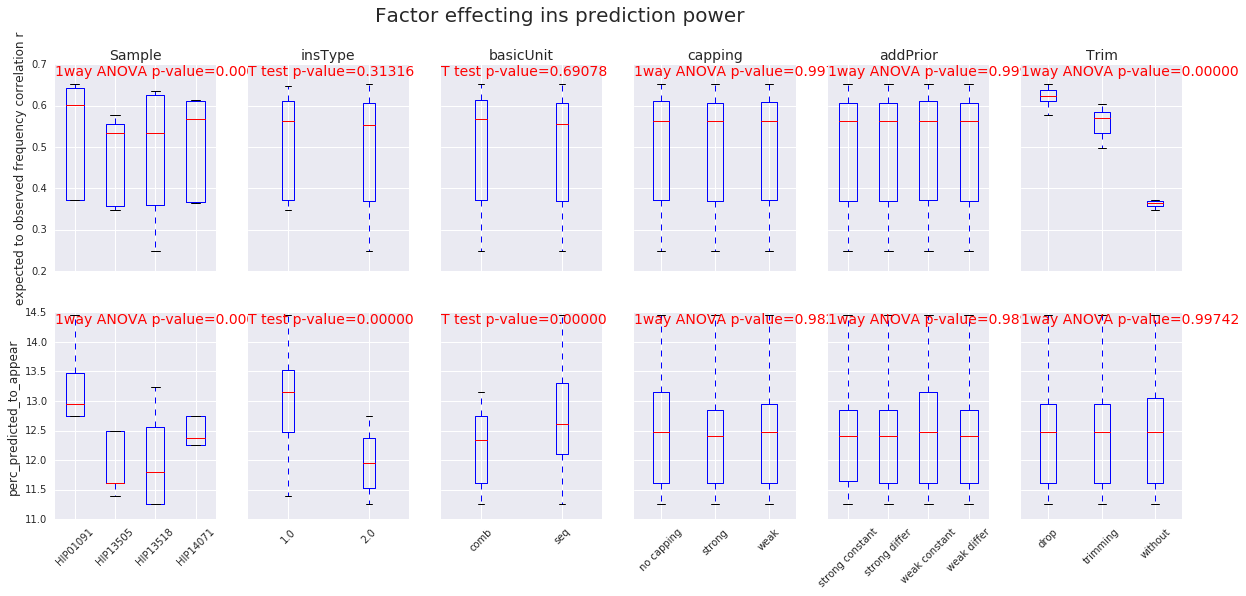

In [66]:
#check effects of different optimization factors on the prediction power:


fig1, ((ax1, ax3,ax5,ax7,ax9,ax11),(ax2,ax4,ax6,ax8,ax10,ax12))= plt.subplots(nrows=2,ncols=6, figsize=(18,8),sharex=False, sharey=False)
fig1.suptitle('Factor effecting ins prediction power', fontsize=20)
axList=[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]
count=0

factors=['Sample', 'insType','basicUnit','capping','addPrior','Trim']
stats=['expected to observed frequency correlation r','perc_predicted_to_appear']

for factor in factors:
    for stat in stats:
        print factor,stat
        fig,ax,s,p=check_category_effect_on_PredictionR(df=ins1OptSummaryDF,category=factor,PredictionR=stat,ax=axList[count])
        ax.set_xlabel("")
        ax.set_title("")
        ax.set_ylabel(stat,fontsize=12)
        
        if count%2==0:
            ax.tick_params(labelbottom='off')
            ax.set_title(factor, fontsize=14)
            
#             ax.xaxis.label.set_visible(False)
        if count>1:
            ax.tick_params(labelleft='off')
            ax.set_ylabel("")
        
        count=count+1
    
fig1.subplots_adjust(left=0.11, right=0.98, top=0.88, bottom=0.09, wspace=0.2,hspace=0.2)

filename='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SuffStat/SuffStat Images/InsOptimizationSummary'
fig1.savefig(filename, bbox_inches='tight', dpi = 200)

plt.show()

Sample expected to observed frequency correlation r
Sample perc_predicted_to_appear
basicUnit expected to observed frequency correlation r
basicUnit perc_predicted_to_appear
capping expected to observed frequency correlation r
capping perc_predicted_to_appear
addPrior expected to observed frequency correlation r
addPrior perc_predicted_to_appear
Trim expected to observed frequency correlation r
Trim perc_predicted_to_appear


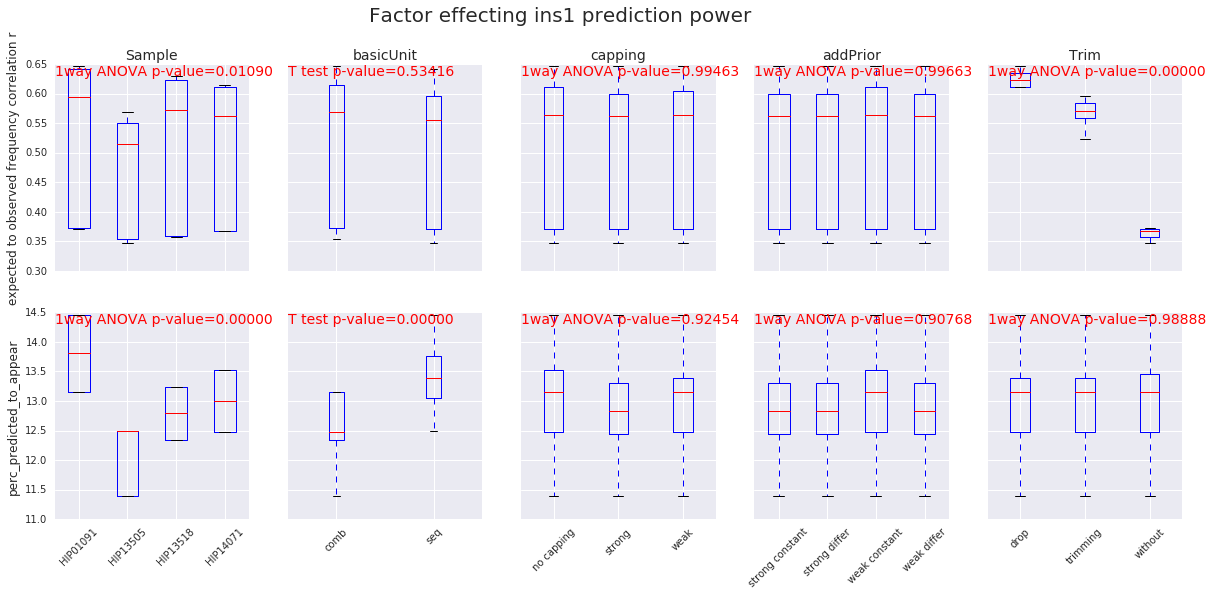

In [67]:
#check effects of different optimization factors on the prediction power seperately for ins1:


fig2, ((ax1, ax3,ax5,ax7,ax9),(ax2,ax4,ax6,ax8,ax10))= plt.subplots(nrows=2,ncols=5, figsize=(18,8),sharex=False, sharey=False)
fig2.suptitle('Factor effecting ins1 prediction power', fontsize=20)
axList=[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]
count=0

factors=['Sample', 'basicUnit','capping','addPrior','Trim']
stats=['expected to observed frequency correlation r','perc_predicted_to_appear']
df=ins1OptSummaryDF[ins1OptSummaryDF['insType']==1]

for factor in factors:
    for stat in stats:
        print factor,stat
        fig,ax,s,p=check_category_effect_on_PredictionR(df=df,category=factor,PredictionR=stat,ax=axList[count])
        ax.set_xlabel("")
        ax.set_title("")
        ax.set_ylabel(stat,fontsize=12)
        
        if count%2==0:
            ax.tick_params(labelbottom='off')
            ax.set_title(factor, fontsize=14)
            
#             ax.xaxis.label.set_visible(False)
        if count>1:
            ax.tick_params(labelleft='off')
            ax.set_ylabel("")
        
        count=count+1
    
fig2.subplots_adjust(left=0.11, right=0.98, top=0.88, bottom=0.09, wspace=0.2,hspace=0.2)

filename='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SuffStat/SuffStat Images/Ins1OptimizationSummary'
fig2.savefig(filename, bbox_inches='tight', dpi = 200)

plt.show()

Sample expected to observed frequency correlation r
Sample perc_predicted_to_appear
basicUnit expected to observed frequency correlation r
basicUnit perc_predicted_to_appear
capping expected to observed frequency correlation r
capping perc_predicted_to_appear
addPrior expected to observed frequency correlation r
addPrior perc_predicted_to_appear
Trim expected to observed frequency correlation r
Trim perc_predicted_to_appear


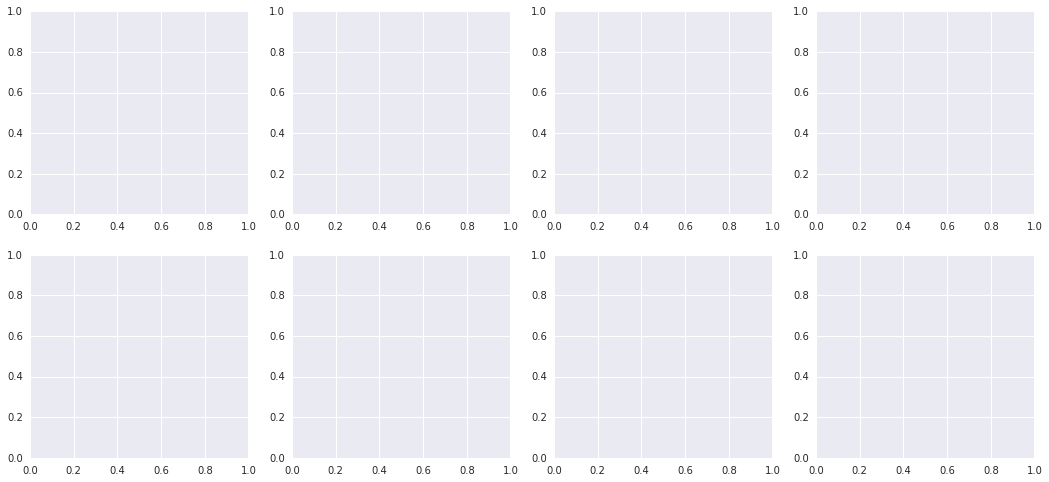

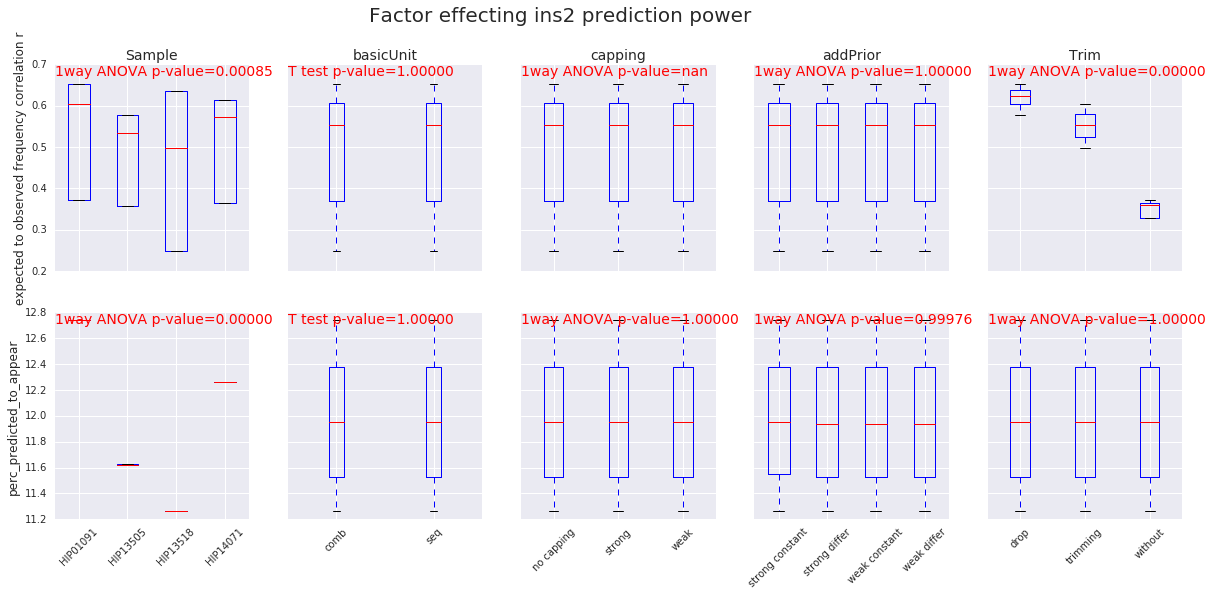

In [69]:
#check effects of different optimization factors on the prediction power seperately for ins2:


fig3, ((ax1, ax3,ax5,ax7,ax9),(ax2,ax4,ax6,ax8,ax10))= plt.subplots(nrows=2,ncols=5, figsize=(18,8),sharex=False, sharey=False)
fig3.suptitle('Factor effecting ins2 prediction power', fontsize=20)
axList=[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]
count=0

factors=['Sample', 'basicUnit','capping','addPrior','Trim']
stats=['expected to observed frequency correlation r','perc_predicted_to_appear']
df=ins1OptSummaryDF[ins1OptSummaryDF['insType']==2]

for factor in factors:
    for stat in stats:
        print factor,stat
        fig,ax,s,p=check_category_effect_on_PredictionR(df=df,category=factor,PredictionR=stat,ax=axList[count])
        ax.set_xlabel("")
        ax.set_title("")
        ax.set_ylabel(stat,fontsize=12)
        
        if count%2==0:
            ax.tick_params(labelbottom='off')
            ax.set_title(factor, fontsize=14)
            
#             ax.xaxis.label.set_visible(False)
        if count>1:
            ax.tick_params(labelleft='off')
            ax.set_ylabel("")
        
        count=count+1
    
fig3.subplots_adjust(left=0.11, right=0.98, top=0.88, bottom=0.09, wspace=0.2,hspace=0.2)

filename='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SuffStat/SuffStat Images/Ins2OptimizationSummary'
fig3.savefig(filename, bbox_inches='tight', dpi = 200)

plt.show()

In [70]:
ins1OptSummaryDF['capping']=ins1OptSummaryDF['capping'].fillna('no capping')

ins1OptSummaryDFgrouped_R=ins1OptSummaryDF.groupby(['insType','basicUnit','capping','addPrior','Trim']).mean()
ins1OptSummaryDFgrouped_R=ins1OptSummaryDFgrouped_R.sort_values(by='perc_predicted_to_appear',ascending=False)
ins1OptSummaryDFgrouped_R[:50]

expected to observed frequency correlation r  \
insType basicUnit capping    addPrior        Trim                                                     
1.0     seq       no capping strong differ   drop                                          0.606295   
                  weak       strong differ   drop                                          0.606295   
                  no capping strong constant trimming                                      0.556634   
                                             drop                                          0.606295   
                             weak constant   without                                       0.361201   
                             weak differ     drop                                          0.606358   
                  strong     strong constant drop                                          0.606295   
                                             trimming                                      0.556634   
                                             without                                       0.361203   
                             strong differ   drop                                          0.606295   
                             weak constant   trimming                                      0.556634   
                             weak differ     without                                       0.361201   
                  weak       strong constant drop                                          0.606295   
                                             trimming                                      0.556634   
                  strong     weak differ     drop                                          0.606358   
                  no capping strong differ   trimming                                      0.556635   
                  weak       weak constant   without                                       0.361201   
                             weak differ     trimming                                      0.556634   
                                             drop                                          0.606358   
                             strong differ   trimming                                      0.556635   
                  no capping weak constant   drop                                          0.606358   
                             strong constant without                                       0.361203   
                  weak       weak differ     without                                       0.361201   
                  no capping weak constant   trimming                                      0.556634   
                             weak differ     trimming                                      0.556634   
                                             without                                       0.361201   
                  weak       strong constant without                                       0.361203   
                  strong     strong differ   trimming                                      0.556635   
                                             without                                       0.361200   
                             weak constant   drop                                          0.606358   
                  weak       weak constant   trimming                                      0.556634   
                  strong     weak constant   without                                       0.361201   
                  no capping strong differ   without                                       0.361200   
                  strong     weak differ     trimming                                      0.556634   
                  weak       weak constant   drop                                          0.606358   
                             strong differ   without                                       0.361200   
        comb      no capping weak constant   without                                       0.366432   
                                      

In [71]:
ins1OptSummaryDF['capping']=ins1OptSummaryDF['capping'].fillna('no capping')

ins1OptSummaryDFgrouped_R=ins1OptSummaryDF.groupby(['insType','basicUnit','capping','addPrior','Trim']).mean()
ins1OptSummaryDFgrouped_R=ins1OptSummaryDFgrouped_R.sort_values(by='expected to observed frequency correlation r',ascending=False)
ins1OptSummaryDFgrouped_R[:50]

expected to observed frequency correlation r  \
insType basicUnit capping    addPrior        Trim                                                     
1.0     comb      no capping weak constant   drop                                          0.630298   
2.0     comb      no capping strong differ   drop                                          0.618986   
        seq       weak       strong differ   drop                                          0.618986   
        comb      weak       strong differ   drop                                          0.618986   
        seq       no capping strong differ   drop                                          0.618986   
        comb      strong     strong differ   drop                                          0.618986   
        seq       strong     strong differ   drop                                          0.618986   
                             strong constant drop                                          0.618969   
                  weak       strong constant drop                                          0.618969   
                  no capping strong constant drop                                          0.618969   
        comb      strong     strong constant drop                                          0.618969   
                  weak       strong constant drop                                          0.618969   
                  no capping strong constant drop                                          0.618969   
        seq       no capping weak differ     drop                                          0.618939   
        comb      no capping weak differ     drop                                          0.618939   
        seq       weak       weak differ     drop                                          0.618939   
        comb      weak       weak differ     drop                                          0.618939   
                  strong     weak differ     drop                                          0.618939   
        seq       strong     weak differ     drop                                          0.618939   
                  no capping weak constant   drop                                          0.618939   
        comb      strong     weak constant   drop                                          0.618939   
        seq       weak       weak constant   drop                                          0.618939   
        comb      weak       weak constant   drop                                          0.618939   
        seq       strong     weak constant   drop                                          0.618939   
        comb      no capping weak constant   drop                                          0.618939   
1.0     comb      no capping strong differ   drop                                          0.614845   
                  weak       strong differ   drop                                          0.614845   
                  strong     strong differ   drop                                          0.614845   
                             weak differ     drop                                          0.614845   
                  no capping weak differ     drop                                          0.614845   
                  weak       weak differ     drop                                          0.614845   
                  no capping strong constant drop                                          0.614845   
                  strong     strong constant drop                                          0.614845   
                  weak       strong constant drop                                          0.614845   
                  strong     weak constant   drop                                          0.614845   
                  weak       weak constant   drop                                          0.614845   
        seq       no capping weak differ     drop                                          0.606358   
                  strong     weak diff

## predicting ins1 within categories

In [ ]:
file1= '/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SampleTagsUpdated.xlsx'
SampleTagsUpdated=pd.read_excel(file1)

In [ ]:
SampleTagsUpdated.head()

In [ ]:
SamplesPerEthnicityDict={}
groupSizes={}


for name,group in SampleTagsUpdated.groupby('Ethnicity2'):
    SamplesPerEthnicityDict[name]=list(group.Sample)
    groupSizes[name]=len(group.Sample)


In [ ]:
 groupSizes

In [ ]:
CaucasianRandomSamples=list(np.random.choice(SamplesPerEthnicityDict['Caucasian'], 7, replace=False))
CaucasianRandomSamples

In [ ]:
BlackAfricanList=list(SamplesPerEthnicityDict['Black or African American'])

### check prediction of ins1 and ins2 by counting and no modeling:
1. count all ins1 sequences in a sample (normalized)
2. count all ins1 sequences in all other samples together (normalized)
3. combine to one dataframe, fill nas with 0's
4. calculate correlation, and how many of the observed sequences appear in the trainset. 
5. repeat for ins2

In [ ]:
Alln1SeqsDFsmall.head()

In [ ]:
AllnsSeqsDFsmall=Alln1SeqsDFsmall
sample_name='HIP01091'

In [ ]:
shortSampleName = sample_name.replace("HIP", "")
trainSet = AllnsSeqsDFsmall[AllnsSeqsDFsmall.index != shortSampleName]
testSet = AllnsSeqsDFsmall[AllnsSeqsDFsmall.index == shortSampleName]

In [ ]:
sampleIns1Counts=testSet['sequence'].value_counts(normalize=True)
trainIns1Counts=trainSet['sequence'].value_counts(normalize=True)

In [ ]:
trainIns1Counts=trainSet['sequence'].value_counts(normalize=True)

In [ ]:
HIP01091ins1PredByCounts=pd.merge(pd.DataFrame(sampleIns1Counts),pd.DataFrame(trainIns1Counts), how='outer',left_index=True, right_index=True)

In [ ]:
HIP01091ins1PredByCounts=HIP01091ins1PredByCounts.fillna(0)

In [ ]:
print len(sampleIns1Counts)
print len(trainIns1Counts)
print len(HIP01091ins1PredByCounts)

In [ ]:
x=HIP01091ins1PredByCounts['sequence_x']
y=HIP01091ins1PredByCounts['sequence_y']
filename='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SuffStat/SuffStat Images/HIP01091ins1PredByCounts'

fig,ax= plt.subplots(nrows=1,ncols=1, figsize=(6,6))
plt.plot(x, y, marker='o', linestyle='', ms=6,alpha=0.4,color='blue')
r,p=MyPearsonr(x,y)

#get locations for p-value text
ylim=ax.get_ylim()
ypos=ylim[1]
xlim=ax.get_xlim()
xpos=xlim[0]
print xpos, ypos

plt.text(xpos,ypos,"r=%.4f p=%.4f" % (r, p),  verticalalignment = 'top', ha = 'left',fontsize=14,color='red')

plot_bestFitLine(x,y)
plt.plot(x, x, 'k-', linewidth=0.5)

fig.savefig(filename=filename, dpi=200)

plt.show()

In [ ]:
exist=HIP01091ins1PredByCounts[HIP01091ins1PredByCounts['sequence_x'].notnull()]
exist.groupby('sequence_y').count()

In [ ]:
#how many sequence appear in the sample and not in any of the other samples:
print len(HIP01091ins1PredByCounts[HIP01091ins1PredByCounts['sequence_x']!=0])
print len(HIP01091ins1PredByCounts[HIP01091ins1PredByCounts['sequence_y']!=0])

onlyInSample=HIP01091ins1PredByCounts[(HIP01091ins1PredByCounts['sequence_y']==0)&(HIP01091ins1PredByCounts['sequence_x']!=0)]
nSeqInSample=len(HIP01091ins1PredByCounts[HIP01091ins1PredByCounts['sequence_x']!=0])
notPredicted=HIP01091ins1PredByCounts[(HIP01091ins1PredByCounts['sequence_y']<0.000021)&(HIP01091ins1PredByCounts['sequence_x']!=0)]
print len(onlyInSample)
print nSeqInSample
print float(len(onlyInSample))*100/nSeqInSample
print float(len(notPredicted))*100/nSeqInSample


## generalize and define function:

In [15]:
insType=2
sample_name='HIP01091'
basicUnit='seq'

In [18]:
def insPredictionByCounts(sample_name, insType,basicUnit):
    
    from myplots import *
    print 'loading ins table...'
    if insType == 1 and basicUnit == 'comb':
        file1 = '/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SuffStat/exp_and_obs_freqs_ins1_dfs/AllinsSeqsDFsmall_ins1_comb'
        AllnsSeqsDFsmall = pd.read_pickle(file1)
    elif insType == 1 and basicUnit == 'seq':
        file1 = '/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SuffStat/exp_and_obs_freqs_ins1_dfs/Alln1SeqsDFsmall'
        AllnsSeqsDFsmall = pd.read_pickle(file1)
    elif insType == 2 and basicUnit == 'comb':
        file1 = '/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SuffStat/exp_and_obs_freqs_ins2_dfs/AllinsSeqsDFsmall_ins2_comb'  
        AllnsSeqsDFsmall = pd.read_pickle(file1)
    elif insType == 2 and basicUnit == 'seq':
        file1 = '/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SuffStat/exp_and_obs_freqs_ins2_dfs/AllinsSeqsDFsmall_ins2_seq'
        AllnsSeqsDFsmall = pd.read_pickle(file1)


    print 'calculating train and test sets....'
    shortSampleName = sample_name.replace("HIP", "")
    trainSet = AllnsSeqsDFsmall[AllnsSeqsDFsmall.index != shortSampleName]
    testSet = AllnsSeqsDFsmall[AllnsSeqsDFsmall.index == shortSampleName]


    print 'value counts...'
    sampleInsCounts=testSet['sequence'].value_counts(normalize=True)
    trainInsCounts=trainSet['sequence'].value_counts(normalize=True)


    print 'calculate correlations and plot...'
    insPredByCounts=pd.merge(pd.DataFrame(sampleInsCounts),pd.DataFrame(trainInsCounts), how='outer',left_index=True, right_index=True)
    #insPredByCounts=insPredByCounts.fillna(0)

    insPredByCounts['log sequence_x']=np.log10(insPredByCounts['sequence_x'])
    insPredByCounts['log sequence_y']=np.log10(insPredByCounts['sequence_y'])
    
    x=insPredByCounts['log sequence_x']
    y=insPredByCounts['log sequence_y']
    filename='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SuffStat/SuffStat Images/Ins%s_Freq_corr_%s_vs_allOthers'

    fig,ax= plt.subplots(nrows=1,ncols=1, figsize=(6,6))
    plt.plot(x, y, marker='o', linestyle='', ms=6,alpha=0.4,color='blue')
    r,p=MyPearsonr(x,y)
    r=round(r,4)
    p=round(p,4)

    #get locations for p-value text
    ylim=ax.get_ylim()
    ypos=ylim[1]
    xlim=ax.get_xlim()
    xpos=xlim[0]
    print xpos, ypos
    
    appearValue=insPredByCounts['sequence_x'].min()
    print appearValue
    roundAppearValue=10**(find_decimal_fold(appearValue)*-1)
    print roundAppearValue
    nSeqInSample=len(insPredByCounts[insPredByCounts['sequence_x']!=0])
    notPredicted=insPredByCounts[(insPredByCounts['sequence_y']<appearValue)&(insPredByCounts['sequence_x']!=0)]
    
    percPred= round(100-(float(len(notPredicted))*100/nSeqInSample),4)
    
    

    plt.text(xpos,ypos,"r=%s,p=%s,perc predicted=%s" %(r, p,percPred),  verticalalignment = 'top', ha = 'left',fontsize=14,color='red')
    plt.xlabel('Observed frequency in sample')
    plt.ylabel('Observed frequency in all other samples')
    plt.title('Ins%s frequency correlation between sample %s and all other samples' %(insType, sample_name))

    plot_bestFitLine(x,y)
    plt.plot(x, x, 'k-', linewidth=0.5)
    #plt.xscale('log')
    #plt.yscale('log')

    fig.savefig(filename=filename, dpi=200)

    plt.show()
    
    return r,p,percPred

<ipython-input-18-cd34e38fdd24>:1: SyntaxWarning: import * only allowed at module level
  def insPredictionByCounts(sample_name, insType,basicUnit):


loading ins table...
calculating train and test sets....
value counts...
calculate correlations and plot...
-4.0 -1.0
0.000132362673726
000132362673726
0.0001


ValueError: Data has no positive values, and therefore can not be log-scaled.

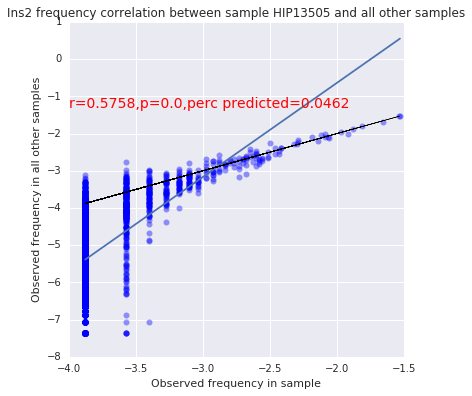

In [19]:
r,p,percPred=insPredictionByCounts(sample_name='HIP13505', insType=2,basicUnit='seq')

In [ ]:
print r,p,percPred

In [ ]:
count=1
for sample_name in sample_list:
    for insType in insTypeList:
        print count, sample_name
        

In [ ]:
def find_decimal_fold(num):
    s_num=str(num)
    fraction=s_num.split('.')[1]
    #print fraction
    fold=0
    for i in range(len(fraction)):
        if fraction[i]!='0':
            fold=i+1
            break
    return fold

In [ ]:
find_decimal_fold(0.00021)

In [11]:
df1=pd.DataFrame({'a':[2,3,4,5],'b':[22,55,66,7]})

In [12]:
df1['log a']=np.log10(df1['a'])

In [13]:
df1

,a,b,log a
0,2,22,0.301030
1,3,55,0.477121
2,4,66,0.602060
3,5,7,0.698970


In [14]:
np.log10(2)

0.3010299956639812